# mad2WTymEGFP inference new objective function 

Set the hyperparameters to $S=3,R=3$.

In [1]:
hypars = [3,3]; # [S,R]
# pf defined for the priors (see SI).
pf = (hypars[1]-1)/2

1.0

Gene number is 4 for mad2WTymEGFP.

In [2]:
gn = 4;

Import the relevant packages and simulations.

In [3]:
using Random, Plots, LaTeXStrings, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures, Revise, GpABC, JLD2, FileIO

In [4]:
Plots.theme(:dao)
Plots.gr_cbar_width[] = 0.01;

In [5]:
Revise.track("/users/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
include("/users/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
using .SSAnonVD

Define a nice colorblind color scheme.

In [6]:
pal = cgrad(:tol_muted);
cpal = [pal[i] for i in 1/7:1/7:1.0]
population_colors = cpal

Import the data.

In [7]:
df_nuc = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/nuclear-vol-corr.csv"));
df_cyto = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/cyto-vol-corr.csv"));
delete!(df_nuc, 2);
delete!(df_cyto, 2);

In [8]:
gnames = df_cyto[!,"gene"]
Ns = df_nuc[!,"N"];
cyto_means = df_cyto[!,"Mean"];
nuc_FFs = df_nuc[!,"FF"];
cyto_FFs = df_cyto[!,"FF"];

In [9]:
gnames[gn]

"mad2WTymEGFP"

Define the timescales necessary to predict the steady-state time. `sim_time` defines the point at which the steady state is assumed to be reached.

In [10]:
tdeg = 1;
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [11]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

Import the values from the bootstrapping for the distance function weighting. It is the inverse of these errors that multiples each square error (larger variance in the sample statistic gives it a lesser weighting in the objective function). 

In [12]:
bootstrapping = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/meanCyto_FF_withVar_forJames_230422.csv"))
ro_df = DataFrame([[] for i in 1:length(names(bootstrapping))], names(bootstrapping)) # empty df
for name in gnames
    ind = findfirst(isequal(name), bootstrapping[!,:gene])
    push!(ro_df, bootstrapping[ind,:])
end
# save("./ABC-new/ABC-redo/bootstrapping.jld", "reordered-BS", ro_df)

In [13]:
# bootstrapping=load("./bootstrapping.jld2")["reordered-BS"];

Take the bootstrapped sample variances (can now use the index `gn` defined above).

In [14]:
bs_cyto = bootstrapping[!,"varmeanRNA_Cytoplasm"][gn]
bs_ffn = bootstrapping[!,"varFF_Nucleus"][gn]
bs_ffc = bootstrapping[!,"varFF_Cytoplasm"][gn];
bs_vec = [bs_cyto, bs_ffn, bs_ffc]

3-element Vector{Float64}:
 0.00140474139621181
 0.00059757251397104
 0.00049411926892847

In [15]:
0.005/0.000597

8.375209380234507

Define the distance function.

In [16]:
function new_distance(traj1::Matrix, traj2::Matrix)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end
function new_distance(traj1::Vector, traj2::Vector)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end

new_distance (generic function with 2 methods)

# Let's do the ABC!

In [17]:
gnames[gn]

"mad2WTymEGFP"

In [18]:
function simulator_fn_3(pars)
    op = SSA(Ns[gn], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_3 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [19]:
new_distance(simulator_fn_3([2.54,3.64,20.0]),reshape([cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]],(3,1)))

236.06343004673568

In [20]:
# ABC priors
priors_3 = [Uniform(pf*0.5,pf*35.5), Uniform(0.5, 10.5), Uniform(0.5,20.5)]

# number of particles
n_particles = 1000

# ABC hpars
threshold_schedule_3 = [200.0, 100.0, 50.0, 25.0, 20.0, 10.0, 5.0]

7-element Vector{Float64}:
 200.0
 100.0
  50.0
  25.0
  20.0
  10.0
   5.0

In [21]:
# sim_abcsmc_res_3 = SimulatedABCSMC(reshape([cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]],(3,1)),
#     simulator_fn_3,
#     priors_3,
#     threshold_schedule_3,
#     n_particles; 
#     max_iter=convert(Int, 1e5),
#     distance_function = new_distance,
#     write_progress=true);

In [22]:
sim_abcsmc_res_3 = load("./S3R3allGenes/S$(hypars[1])R$(hypars[2])_$(gnames[gn]).jld2", "ABC");

Quick look at the results...

In [23]:
plot(sim_abcsmc_res_3, population_colors=population_colors)

Save these results using the JLD package.

In [24]:
# save("./S3R3allGenes/S$(hypars[1])R$(hypars[2])_$(gnames[gn]).jld2", "ABC", sim_abcsmc_res_3)

Let's collect the important aspects of this ABC for analysis. We want:
- 1. The parameter values of the accepted particles.
- 2. The acceptance rate for the final threshold.

Note the different field names are: `n_accepted`, `n_tries`, `threshold_schedule`, `population`, `distances`, `weights`.

In [25]:
acc_rate = sim_abcsmc_res_3.n_accepted[end]/sim_abcsmc_res_3.n_tries[end]

0.015169442674676133

So the acceptance rate at the final threshold was around 0.2. Let's now look at the mean and standard deviations of the predicted values of $k_A$, $k_B$ and $k_C$ from the population.

In [26]:
pop = sim_abcsmc_res_3.population[end];

In [27]:
kA = pop[:,1]; kB = pop[:,2]; kC = pop[:,3];

In [28]:
kAmed = median(kA)

15.726381668819606

In [29]:
kAstd = std(kA)

2.5467803422427213

In [30]:
kBmed = median(kB)

1.355848514510275

In [31]:
kBstd = std(kB)

0.09885503083732061

In [32]:
kCmed = median(kC)

3.8547037288629027

In [33]:
kCstd = std(kC)

1.2828336404102993

Let's make some nice plots of these (the three histograms followed by the joint uncertainty plots as a 2D hist).

In [56]:
h1 = stephist(kA, fill = true, fillalpha = 0.5, color = cpal[1], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_A", title = L"(a) $\sigma =$ %$(round(kAstd,sigdigits = 3))", ylims = [0,0.2])
plot!([kAmed,kAmed],[0,100], style = :dash, color = :black, label = L"$k_A$ median");

In [64]:
h2 = stephist(kB, fill = true, fillalpha = 0.5, color = cpal[2], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_B", title = L"(b) $\sigma =$ %$(round(kBstd,sigdigits = 3))", ylims = [0,4.5])
plot!([kBmed,kBmed],[0,10.0], style = :dash, color = :black, label = L"$k_B$ median");

In [68]:
h3 = stephist(kC, fill = true, fillalpha = 0.5, color = cpal[3], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_C", 
        title = L"(c) $\sigma =$ %$(round(kCstd,sigdigits = 3))", ylims = [0,0.35])
plot!([kCmed,kCmed],[0,2], style = :dash, color = :black, label = L"$k_C$ median");

In [69]:
c1 = plot(h1, h2, h3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm);

In [70]:
p1 = histogram2d(kA, kB, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA):(maximum(kA)-minimum(kA))/15:maximum(kA)), collect(minimum(kB):(maximum(kB)-minimum(kB))/15:maximum(kB))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_B", title = "(d) Corr. coeff. $(round(cor(kA,kB),sigdigits=3))");

In [71]:
p2 = histogram2d(kA, kC, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA):(maximum(kA)-minimum(kA))/15:maximum(kA)), collect(minimum(kC):(maximum(kC)-minimum(kC))/15:maximum(kC))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_C", title = "(e) Corr. coeff. $(round(cor(kA,kC),sigdigits=3))");

In [72]:
p3 = histogram2d(kB, kC, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kB):(maximum(kB)-minimum(kB))/15:maximum(kB)), collect(minimum(kC):(maximum(kC)-minimum(kC))/15:maximum(kC))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_B", ylabel = L"k_C", title = "(f) Corr. coeff. $(round(cor(kC,kB),sigdigits=3))");

In [73]:
c2 = plot(p1, p2, p3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm, left_margin = 5.0mm, right_margin = -10mm);

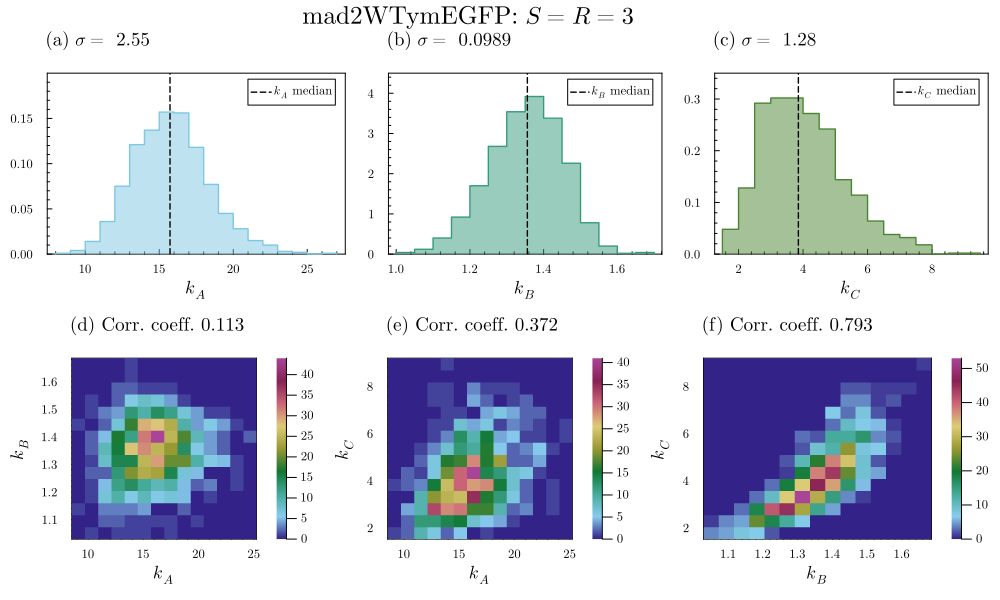

In [76]:
plot(c1,c2, layout = (2,1), size = (1000,600), plot_title=L"%$(gnames[gn]): $S=R=3$")
# savefig("./S$(hypars[1])R$(hypars[2])_$(gnames[gn]).pdf")

Check if the moments replicate those from the original data.

In [43]:
[cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]]

3-element Vector{Float64}:
 2.89691333108192
 0.845001486200982
 0.82426466149224

In [44]:
mean([simulator_fn_3([kAmed,kBmed,kCmed]) for i in 1:100])

3×1 Matrix{Float64}:
 2.912800261096605
 0.9013702223328479
 0.8206695744559953

So, pretty good overall.